STEP 1. **Data Collection**
  -

1.	Obtain the data

In [94]:
import pandas as pd
df=pd.read_csv('IMDB_Dataset[1].csv')
df.columns = df.columns.str.strip().str.lower()
print(df[['review', 'sentiment']].head())
print("Dataset Shape:", df.shape)
print("Sentiment Counts:\n", df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Dataset Shape: (50000, 2)
Sentiment Counts:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


2.	Database Setup

In [96]:
import sqlite3
conn = sqlite3.connect("imdb_reviews.db")
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS imdb_reviews (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        review_text TEXT,
        sentiment TEXT
    )
''')
df[['review', 'sentiment']].to_sql('imdb_reviews', conn, if_exists='replace', index=False)
conn.commit()
conn.close()
print("✅ Data successfully stored in the database!")

✅ Data successfully stored in the database!


Step 2. **Data Cleaning & Exploration**
-

1.	Data Cleaning
    - We will:
    - ✅ Convert text to lowercase
    - ✅ Remove HTML tags
      
    - ✅ Remove punctuation (optional)
    - ✅ Remove duplicates

In [98]:
import re
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Lowercasing
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text
    return ""
df['cleaned_review'] = df['review'].apply(clean_text)
print("Empty reviews after cleaning:", (df['cleaned_review'] == "").sum())


Empty reviews after cleaning: 0


2.	Exploratory Data Analysis (EDA)

We will: 
- ✅ Check positive vs. negative review distribution
- ✅ Calculate average review length
- ✅ Visualize word frequency

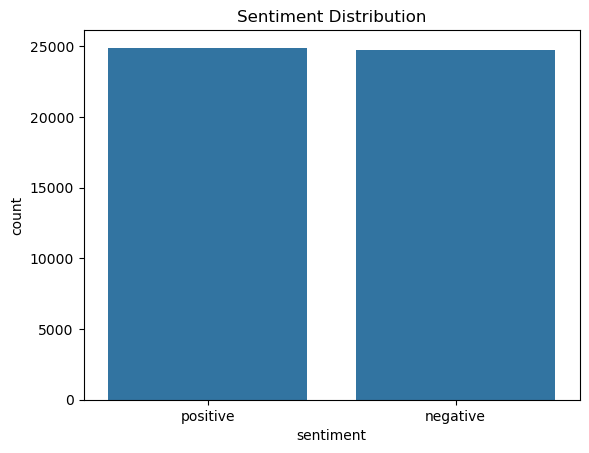

             count        mean         std   min    25%    50%    75%     max
sentiment                                                                    
negative   24696.0  224.477405  161.157078   4.0  125.0  171.0  272.0  1473.0
positive   24884.0  228.306743  173.989442  10.0  123.0  169.0  277.0  2450.0


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x=df['sentiment'])
plt.title("Sentiment Distribution")
plt.show()
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
print(df.groupby('sentiment')['review_length'].describe())

In [66]:
print(df['sentiment'].isnull().sum())
df = df.dropna(subset=['sentiment'])
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print(df['sentiment'].isnull().sum())

0
0


 Step 4: Model Training
-

🔹 Step 4.1: Convert Text to Numerical Features
Since machine learning models can’t process raw text, we will:
- ✅ Convert reviews into TF-IDF vectors (Term Frequency-Inverse Document Frequency).
- ✅ Split data into train and test sets.

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') 
X = vectorizer.fit_transform(df['cleaned_review'])
print("✅ TF-IDF Vectorization Successful! Vocabulary size:", len(vectorizer.get_feature_names_out()))


✅ TF-IDF Vectorization Successful! Vocabulary size: 5000


🔹Step 4.2:	Train/Validation Split

In [148]:
from sklearn.model_selection import train_test_split
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Data successfully split! Train size:", X_train.shape, "Test size:", X_test.shape)

✅ Data successfully split! Train size: (40000, 5000) Test size: (10000, 5000)


🔹Step 4.3: Training

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Training Completed! Accuracy: {accuracy:.4f}")

✅ Model Training Completed! Accuracy: 0.8833


🔹Step 4.4: Evaluation

In [139]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      4961
    positive       0.87      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



 Save the Model & Vectorizer
-

In [141]:
import pickle
with open("sentiment_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)
with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
print("✅ Model and Vectorizer Saved Successfully!")

✅ Model and Vectorizer Saved Successfully!


Now, GO TO Python file (Flask_app.py) for the Flask API 
-

In [156]:
import requests

url = "http://127.0.0.1:5000/predict"
data = {"review_text": "This movie was bad"}

response = requests.post(url, json=data)
print(response.json()) 


{'sentiment_prediction': 'negative'}
